* Prepared by Richard (Yu) Liu, 04/2025, https://scholar.google.com/citations?user=f8aS9_0AAAAJ&hl=en


# Import packages

In [1]:
!pip install botorch
!pip install gpytorch
!pip install numba
!pip install spmsimu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Download the ground-truth rewards and the topography for simulation

!gdown 15fkNbfxmgf5ertBdcygXkDo1jP1WNHeH
!gdown 1goI3GARSyHh9JDjZHbFgYfovw_FjTgG4

Downloading...
From: https://drive.google.com/uc?id=15fkNbfxmgf5ertBdcygXkDo1jP1WNHeH
To: /content/droplets.npy
100% 2.10M/2.10M [00:00<00:00, 59.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1goI3GARSyHh9JDjZHbFgYfovw_FjTgG4
To: /content/rewards_multiple2.npy
100% 240k/240k [00:00<00:00, 70.3MB/s]


In [3]:
# Simulator related packages

import numpy as np
from numba import jit, njit, prange
import matplotlib.pyplot as plt
from matplotlib import rcParams

import os

from IPython.display import display, clear_output
import random

In [4]:
# AC-BO related packages

import torch

from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize

from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, LogExpectedImprovement
from gpytorch.distributions import MultivariateNormal
import gpytorch

import warnings
warnings.filterwarnings('ignore')

# from jax.lib import xla_bridge

# print(xla_bridge.get_backend().platform)

In [5]:
# AC-MOBO related packages

from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.utils.transforms import unnormalize, normalize
from botorch.utils.sampling import draw_sobol_samples

from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement

from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.multi_objective.box_decompositions.non_dominated import (
    FastNondominatedPartitioning,
)
from botorch.acquisition.multi_objective.monte_carlo import (
    qExpectedHypervolumeImprovement,
    qNoisyExpectedHypervolumeImprovement,
)
from botorch.utils.sampling import sample_simplex

import time
import warnings

# from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.dominated import (
    DominatedPartitioning,
)
from botorch.utils.multi_objective.pareto import is_non_dominated

In [6]:
tkwargs = {
    "dtype": torch.float64,
    # "device": "cpu",
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

print(tkwargs['device'])

cpu


# Pre-define functions

## Experiment objects to run the simulation

In [7]:
import types

class Experiment(object):
    '''
    Experiment data structure for SPM auto-optimization simulation.
    '''
    def __init__(self):
        super(Experiment, self).__init__()

        # Initialize parameter dict
        self.param = {}

    def update_param(self, key, value):
        '''
        Update the value stored in obj.param

        Input:
            key     - List: keys to be modifies in obj.param
            value   - List: values to be entered in obj.param['key']

        Output:
            N/A

        Usage:
            obj.update_param(key=['DriveAmplitude', 'Setpoint'], value=[0.1, 0.2])
        '''
        if type(key) is not list:
            key = [key]

        if len(key) == 1:
            self.param[key[0]] = value

        else:
            for i, ix in enumerate(key):
                self.param[ix] = value[i]

    def add_func(self, NewFunc):
        '''
        Add a custom function as the method to Experiment object.

        Input:
            NewFunc - Function: Custom function defined by user. This function has aceess
                        to all the attributes and methods of obj
        Output:
            N/A
        Usage:
            def measure(self, operation, key, value):
                self.update_param(key=key, value=value)
                self.execute(operation)
            obj.add_func(measure)
        '''

        method_name = NewFunc.__name__

        # add new function name to the custom action list
        # self.action_list[method_name] = method_name

        # Bind the function as a method of the instance
        bound_method = types.MethodType(NewFunc, self)

        # Set the method to the instance
        setattr(self, method_name, bound_method)

In [8]:
# Here is the function to remove the latency between trace and retrace

from scipy.interpolate import CubicSpline
from scipy.optimize import minimize

def diff_shifted(y1, y2, thres=0.1):
    '''
    Find the optimal x-shift of y2 with respect to y1 that minimizes the absolute
    difference between y1 and y2_shifted. If the amount of shift is larger than
    thres * len(y1), the original y1 and y2 will be returned.

    Input:
        y1   - list: 1D scan trace/retrace
        y2   - list: 1D scan trace/retrace
        thres- list: threshold to determine if fitting is failed. If x_shift is
                    greater than thres * len(y1), original y1 and y2 will be returned.

    Returns:
        y1_cut     - y1 is cut to keep overlapped part with y2_shifted
        y2_shifted - shifted y2 array

    Usage:
        y1_shifted, y2_shifted = diff_shifted(y1, y2)

    '''
    # Initial guess for the shift
    initial_shift = 0

    x = np.arange(len(y1))

    # Run the optimization
    result = minimize(mse_shift, initial_shift, args=(x, y1, y2))

    # Best shift found
    best_shift = result.x

    # Create a spline of the second trace
    spline = CubicSpline(x, y2)

    # Shift x values by the found optimal shift
    x_shifted = x - best_shift

    # Evaluate the shifted trace at the original x values
    y2_optimal_shifted = spline(x_shifted)

    if np.abs(best_shift) > thres * len(y1):
        return y1, y2
    elif best_shift > 0:
        return y1[int(best_shift)+1:], y2_optimal_shifted[int(best_shift)+1:]
    elif best_shift < -1:
        return y1[:int(best_shift)-1], y2_optimal_shifted[:int(best_shift)-1]
    else:
        return y1, y2

def mse_shift(shift, x, y1, y2):
    # Create a spline of the second trace
    spline = CubicSpline(x, y2)

    # Shift x values
    x_shifted = x - shift

    # Evaluate the shifted trace at the original x values
    y2_shifted = spline(x_shifted)

    # Compute the MSE between the original and shifted traces
    mse = np.mean((y1 - y2_shifted)**2)
    return mse

In [9]:
import numpy as np

def pearson_correlation(ts1, ts2):
    """
    Calculate the Pearson Correlation Coefficient between two time series.
    Assumes both time series are normalized.
    """
    ts1_mean = np.mean(ts1)
    ts2_mean = np.mean(ts2)

    numerator = np.sum((ts1 - ts1_mean) * (ts2 - ts2_mean))
    denominator = np.sqrt(np.sum((ts1 - ts1_mean)**2) * np.sum((ts2 - ts2_mean)**2))

    return numerator / denominator

In [10]:
from spmsimu.simulator import *

# from simulator import *

# Reward functions

## Single reward function

Uncomment the code below if you want to try single-reward BO

In [ ]:
# # from numba import jit, njit, prange

# norm_ = lambda x: (x - np.min(x)) / np.ptp(x)

# def reward_grid(h1, h2, ph1, ph2, offset=0):

#     h2 = h2[:, ::-1]
#     ph2 = ph2

#     ph1, ph2 = diff_shifted(ph1, ph2)

#     ph1_norm, ph2_norm = norm_(ph1), norm_(ph2)

#     diff = np.abs(ph1_norm - ph2_norm)

#     # index3 = np.where((ph1 - offset > 90) & (ph1 - offset < 120))
#     # index4 = np.where((ph2 - offset > 90) & (ph2 - offset < 120))

#     # phase_above_factor = (len(index3[0]) + len(index4[0])) / len(h1) * 50
#     # phase_above_factor = np.e if phase_above_factor <= np.e else phase_above_factor

#     height_trace_factor = np.abs(np.mean(diff)) * 1e2

#     base =  height_trace_factor #* 1 * 1 # / np.log(phase_above_factor) / 1

#     similarity = (1 + pearson_correlation(ph1_norm, ph2_norm)) * 1e2

#     index1 = np.where(ph1 -  offset < 90)
#     index2 = np.where(ph2 -  offset < 90)

#     ph1_masked1 = np.copy(ph1)
#     ph1_masked1[np.where(ph1 - offset > 90)] = 90

#     ph2_masked1 = np.copy(ph2)
#     ph2_masked1[np.where(ph2 - offset > 90)] = 90

#     m1 = np.sum(90 + offset-ph1_masked1)
#     m2 = np.sum(90 + offset-ph2_masked1)

#     phase_below_factor = np.e if m1 * m2 <= np.e else m1 * m2

#     return -np.log(np.abs(base * np.log(phase_below_factor) * log(similarity)))


## Multiple reward functions

In [11]:
# def multiple_rewards(h1, h2, ph1, ph2, offset=0):
#     h2 = h2[:, ::-1]
#     ph2 = ph2

#     h1, h2 = diff_shifted(h1, h2)

#     h1_norm, h2_norm = norm_(h1), norm_(h2)

#     diff = np.abs(h1_norm - h2_norm)

#     # index3 = np.where((ph1 - offset > 90) & (ph1 - offset < 120))
#     # index4 = np.where((ph2 - offset > 90) & (ph2 - offset < 120))

#     # phase_above_factor = (len(index3[0]) + len(index4[0])) / len(h1) * 50
#     # phase_above_factor = np.e if phase_above_factor <= np.e else phase_above_factor

#     height_trace_factor = np.abs(np.mean(diff)) * 1e2

#     base =  height_trace_factor #* 1 * 1 # / np.log(phase_above_factor) / 1

#     similarity = (1 - pearson_correlation(h1_norm, h2_norm)) * 10 + np.e

#     index1 = np.where(ph1 -  offset < 90)
#     index2 = np.where(ph2 -  offset < 90)

#     ph1_masked1 = np.copy(ph1)
#     ph1_masked1[np.where(ph1 - offset > 90)] = 90

#     ph2_masked1 = np.copy(ph2)
#     ph2_masked1[np.where(ph2 - offset > 90)] = 90

#     m1 = np.sum(90 + offset-ph1_masked1)
#     m2 = np.sum(90 + offset-ph2_masked1)

#     phase_below_factor = np.e if m1 * m2 <= np.e else m1 * m2
#     phase_factor2 = np.mean(np.abs(ph1-120)) + 1
#     # similarity = np.e if similarity <= np.e else similarity

#     return np.array([-base, -phase_factor2*np.log(phase_below_factor), -np.log(similarity)])

norm_ = lambda x: (x - np.min(x)) / np.ptp(x)

def multiple_rewards(h1, h2, ph1, ph2, offset=0):
    h2 = h2[:, ::-1]
    ph2 = ph2

    # h1, h2 = diff_shifted(h1, h2)

    h1_norm, h2_norm = norm_(h1), norm_(h2)

    diff = np.abs(h1_norm - h2_norm)

    height_trace_factor = np.abs(np.mean(diff)) * 1e2

    base =  height_trace_factor #* 1 * 1 # / np.log(phase_above_factor) / 1

    similarity = (1 - pearson_correlation(h1_norm, h2_norm)) * 10 + np.e

    # Compute phase adjustments
    ph1_masked = np.where(ph1 - offset > 90, 90, ph1)
    ph2_masked = np.where(ph2 - offset > 90, 90, ph2)

    m1 = np.sum(90 + offset - ph1_masked)
    m2 = np.sum(90 + offset - ph2_masked)

    phase_below_factor = max(np.e, m1 * m2)

    phase_factor2 = np.mean(np.abs(ph1-120)) + np.e
    # similarity = np.e if similarity <= np.e else similarity

    return np.array([-base, -phase_factor2*np.log(phase_below_factor), -np.log(similarity)])

In [12]:
# First of all, we need to define the behaviors of probes at too-large setpoint

# 1. it will be at a much higher height than the sample surface (long-range interaction)
# 2. it will be dominated by the random noise too
# 3. this part takes effect in the "Measure function"

def measure_with_noise(self, drive, setpoint, i_gain=1e0, repeat=1, reward=True, trace=False):

    # We need to simulate the fwd and bkd scans with the scanning parameters
    i_gain = 1e-2 if i_gain is None else i_gain
    # small enough setpoint case
    z1, ph1, z2, ph2 = scan(image=self.param['image'], kernel=self.param['kernel'], drive=drive,
                            setpoint=setpoint, I=i_gain, phase=True, retrace=True, noise=True)

    traces = []
    out = multiple_rewards(z1, z2, ph1, ph2, offset=0)

    if trace:
        traces.append([z1, z2, ph1, ph2])
        return out, traces
    else:
        return out

def measure_with_noise_single(self, drive, setpoint, i_gain=1e0, repeat=1, reward=True, trace=False):

    # We need to simulate the fwd and bkd scans with the scanning parameters
    i_gain = 1e-2 if i_gain is None else i_gain
    # small enough setpoint case
    z1, ph1, z2, ph2 = scan(image=self.param['image'], kernel=self.param['kernel'], drive=drive,
                            setpoint=setpoint, I=i_gain, phase=True, retrace=True, noise=True)

    traces = []
    out = multiple_rewards(z1, z2, ph1, ph2, offset=0)
    out = -np.log(-out[0] * (-out[1])*(-out[2]))
    if trace:
        traces.append([z1, z2, ph1, ph2])
        return out, traces
    else:
        return out

## Grid-search of multiple rewards

Text(0.5, 1.0, 'Image with real tip')

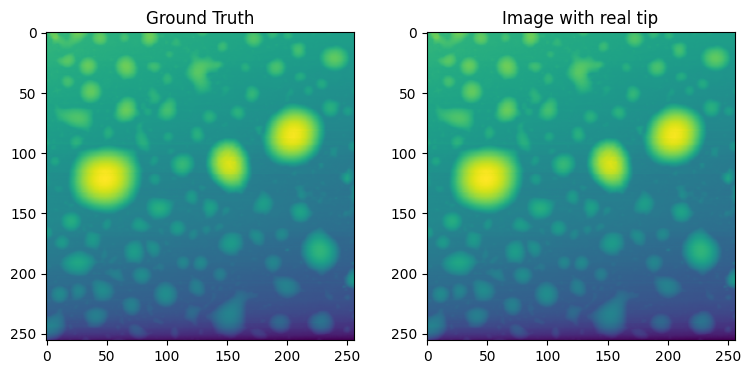

In [13]:
import os

droplets = np.load('droplets.npy')
np.shape(droplets)

# Generate the checkerboard pattern
# img = generate_checkerboard(nx=256, ny=256, n_box=10)
# img = norm_(at.lineSubtract(droplets[0], 1))
img = norm_(droplets[0])

Lx, Ly = np.shape(img)

kernel_size = 50
wx = 2.5   # x width of the probe
wy = 2.5   # y width of the probe

kernel_1 = generate_tip_kernel(kernel_size, wx, wy, tip_height=1)

z_checkerboard = tip_scan(img, kernel_1)

fig, ax=plt.subplots(1,2,figsize=[9,4])
ax[0].imshow(img)
ax[1].imshow(z_checkerboard)

ax[0].set_title('Ground Truth')
ax[1].set_title('Image with real tip')

In [14]:
from numba import njit, prange
import numpy as np

@njit
def norm_(x):
    return (x-np.min(x)) / np.ptp(x)

@njit
def pearson_correlation(ts1, ts2):
    """
    Calculate the Pearson Correlation Coefficient between two time series.
    Assumes both time series are normalized.
    """
    ts1_mean = np.mean(ts1)
    ts2_mean = np.mean(ts2)

    numerator = np.sum((ts1 - ts1_mean) * (ts2 - ts2_mean))
    denominator = np.sqrt(np.sum((ts1 - ts1_mean)**2) * np.sum((ts2 - ts2_mean)**2))

    return numerator / denominator

@njit
def reward_grid(h1, h2, ph1, ph2, setpoint=1, offset=0):
    """
    Compute the reward based on height and phase differences.
    """
    h2 = h2[:, ::-1]
    ph2 = ph2

    h1_norm, h2_norm = norm_(h1), norm_(h2)

    diff = np.abs(h1_norm - h2_norm)

    height_trace_factor = np.abs(np.mean(diff)) * 1e2

    base =  height_trace_factor #* 1 * 1 # / np.log(phase_above_factor) / 1

    similarity = (1 - pearson_correlation(h1_norm, h2_norm)) * 10 + np.e

    # Compute phase adjustments
    ph1_masked = np.where(ph1 - offset > 90, 90, ph1)
    ph2_masked = np.where(ph2 - offset > 90, 90, ph2)

    m1 = np.sum(90 + offset - ph1_masked)
    m2 = np.sum(90 + offset - ph2_masked)

    phase_below_factor = max(np.e, m1 * m2)

    phase_factor2 = np.mean(np.abs(ph1-120)) + np.e
    # similarity = np.e if similarity <= np.e else similarity

    return np.array([-base, -phase_factor2*np.log(phase_below_factor), -np.log(similarity)])


@njit(parallel=True)
def measure_grid(img, kernel, drive, setpoint, i_gain=1e0, reward=True, trace=False):
    """
    Simulate forward and backward scans and compute rewards.
    """
    N1 = len(drive)
    N2 = len(setpoint)
    rewards = np.zeros((N1, N2, 3))

    for i in prange(N1):  # Parallel outer loop
        for j in range(N2):
            # Replace `scan()` with your implementation
            # print('Working on:{}/{}'.format(i*N1+j, N1*N2))
            z1, ph1, z2, ph2 = scan(img, kernel, drive[i], setpoint[j], i_gain, phase=True, retrace=True, noise=True)
            rewards[i, j] = reward_grid(z1, z2, ph1, ph2)

    return rewards



In [ ]:
# # Uncomment this cell if you want to run the benchmarking on a dense grid
# # Warning: this cell will take ~30 min to finish. Please run it locally as Colab may kill your kernel

# # Example use
# x1 = np.linspace(0.01, 1, num=100)
# x2 = np.linspace(0.01, 1, num=100)

# # Ensure `img` and `kernel_1` are appropriately defined
# rewards = measure_grid(img, kernel_1, drive=x1, setpoint=x2)
# np.save('output/rewards_multiple.npy', rewards)
# # np.savetxt('rewards_test2.txt', rewards)

In [15]:
# This is the ground truth grid-search rewards
rewards = np.load('rewards_multiple2.npy')
# rewards

## MOBO setup

Data structure of MOBO:

Assume that we have __N__ variables: $x_1$, $x_2$, ..., $x_N$

and there are __Q__ rewards: $y_1$, $y_2$, ..., $y_Q$

suppose we have done __M__ measurements.

__train_x:__ torch.Size([M, N])

__train_y__ and __train_y_var__: torch.Size([M, Q])

Notice that there are __Q__ SingleTaskGP used to model the relation between each of the reawrd with the train_x.

About the reference points (from Chat-GPT):

1. Farther from the Pareto Front:

- The reference point should be located outside the space dominated by the current Pareto front, ensuring all Pareto-optimal solutions contribute to the hypervolume.
- If the reference point is within or too close to the Pareto front, the hypervolume calculation may become inaccurate.
Based on Problem Knowledge:

2. Use domain-specific knowledge to set the reference point. For instance, in a maximization problem, the reference point could be slightly worse than the worst acceptable values for each objective.
3. Empirical Choice:

- If you lack domain knowledge, you can set the reference point slightly below (for maximization) or above (for minimization) the worst observed objective values in your data. For example:
python
```Python
reference_point = torch.min(Y, dim=0).values - delta  # Maximization
```
where Y is the tensor of observed outcomes and delta is a small offset.
4. Normalization:

- If you have normalized objectives (e.g., scaled to [0, 1]), the reference point should also be specified in this normalized space. For example:
python

______________________________________________
__Practical Tips__
1. Choice of delta:

- Ensure delta is large enough to avoid the reference point being dominated by any observed points. A value between 5% and 10% of the range of objectives often works well.
2. Adaptation Over Iterations:

- If the range of objectives changes significantly during optimization, you may need to adjust the reference point dynamically to reflect the updated knowledge.
3. Tools in BoTorch:

- In BoTorch, you pass the reference point to the acquisition function, e.g., qExpectedHypervolumeImprovement, like this:
python
```Python
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement

ref_point = torch.tensor([1.1, 1.1]).to(device)  # Example reference point
qEHVI = qExpectedHypervolumeImprovement(
    model=model,
    ref_point=ref_point,
    partitioning=partitioning,
)
```
4. Visualization and Debugging
- Visualizing the objectives, Pareto front, and hypervolume can help in choosing and validating the reference point. In 2D problems, for instance, plot the objective space with the Pareto front and the chosen reference point to ensure it's well-positioned.

- By carefully setting the reference point, you ensure the optimization process effectively measures improvement and drives the search toward better Pareto-optimal solutions.

### Import necessary packages

In [16]:
import time
import warnings

from botorch import fit_gpytorch_mll
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.dominated import (
    DominatedPartitioning,
)
from botorch.utils.multi_objective.pareto import is_non_dominated

In [17]:
import os
import torch


tkwargs = {
    "dtype": torch.double,
    # 'device': 'cpu',
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
SMOKE_TEST = os.environ.get("SMOKE_TEST")

if torch.cuda.is_available():
    print('GPU')
else:
    print('CPU')

CPU


In [18]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.utils.transforms import unnormalize, normalize
from botorch.utils.sampling import draw_sobol_samples

from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement

from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.multi_objective.box_decompositions.non_dominated import (
    FastNondominatedPartitioning,
)
from botorch.acquisition.multi_objective.monte_carlo import (
    qExpectedHypervolumeImprovement,
    qNoisyExpectedHypervolumeImprovement,
)
from botorch.utils.sampling import sample_simplex

### Generate seeds

In [19]:
def generate_seed_mobo(self, num=10, repeat=1, seed=None):

    if seed is None:
        np.random.seed(35)

    X = self.param['X_array']

    idx = np.random.randint(0, len(X), num)

    X_measured = X[idx]
    X_exp_measured = self.param['X_exp'][idx]

    y_measured = np.zeros([len(idx), 3])

    mask = np.ones(len(idx))

    indices_measured = idx
    indices_unmeasured = np.delete(np.arange(len(X)), idx, 0)

    self.update_param('num_seed', num)
    self.update_param('idx', idx)
    self.update_param('indices_unmeasured_seed', indices_unmeasured)
    self.update_param('indices_measured_seed', indices_measured)

    for i in range(num):
        if len(X_measured[i]) == 2:
            drive, setpoint = X_measured[i]
            i_gain = None
        else:
            drive, setpoint, i_gain = X_measured[i]

        y_measured[i], traces = self.measure_with_noise(drive=drive, setpoint=setpoint,
                                                        i_gain=i_gain, repeat=repeat, trace=True)

        plot_seed_mobo(traces, i)

        self.update_param(key='index', value=(i+1) * repeat)

    fig, ax = plt.subplots(1,3, figsize=[10,3])
    ax[0].scatter(X_exp_measured[:, 1], X_exp_measured[:, 0], c=y_measured[:,0], s=160, marker='s')
    ax[1].scatter(X_exp_measured[:, 1], X_exp_measured[:, 0], c=y_measured[:,1], s=160, marker='s')
    ax[2].scatter(X_exp_measured[:, 1], X_exp_measured[:, 0], c=y_measured[:,2], s=160, marker='s')

    for axis in ax:
        axis.set_xlabel('Setpoint')
        axis.set_ylabel('Drive Amplitude')

    plt.tight_layout()

    X_unmeasured = np.delete(X, idx, axis=0)
    X_exp_unmeasured = np.delete(self.param['X_exp'], idx, axis=0)

    y_measured = np.asarray(y_measured, dtype=np.float64)

    self.update_param('X_measured_array_seed', X_measured)

    self.update_param('X_exp_measured', X_exp_measured)
    self.update_param('X_exp_unmeasured', X_exp_unmeasured)

    self.update_param('X_exp_measured_seed', X_exp_measured)
    self.update_param('X_exp_unmeasured_seed', X_exp_unmeasured)

    self.update_param('X_unmeasured_array_seed', X_unmeasured)
    self.update_param('y_measured_array_seed', y_measured)

    self.update_param('X_measured_tensor_seed', torch.from_numpy(X_measured))
    self.update_param('X_unmeasured_tensor_seed', torch.from_numpy(X_unmeasured))
    self.update_param('y_measured_tensor_seed', torch.from_numpy(y_measured))

def plot_seed_mobo(traces, i):

    clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=200)

    h1, h2, ph1, ph2 = traces[0]

    ax[0].imshow(h1)
    ax[1].imshow(ph1)
    ax[0].set_title("Traces at sample={}".format(i+1))
    plt.tight_layout()
    plt.show()

## MOBO fitting function

In [20]:
def step_mobo(self, acquisition='qNEHVI', beta=4, delta=5, MC_SAMPLES = 128,
              N_BATCH = 20, BATCH_SIZE=1, NUM_RESTARTS = 10, EPSILON=0.05, RAW_SAMPLES = 512):

    bounds = torch.stack([torch.ones(2), 1 * torch.ones(2)]).to(self.param['device'])

    standard_bounds = torch.zeros(2, 2, dtype=torch.float32).to(self.param['device'])
    standard_bounds[1] = 1

    train_x = self.param['X_measured_tensor'].to(self.param['device'])
    train_obj = self.param['y_measured_tensor'].to(self.param['device'])

    X = self.param['X_tensor'].to(self.param['device'])

    # Initialize the model
    models = []

    for i in range(train_obj.shape[-1]):
        train_y = train_obj[..., i : i + 1]
        models.append(
            SingleTaskGP(
                train_x, train_y, #outcome_transform=Standardize(m=1)
            )
        )

    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    fit_gpytorch_mll(mll)

    # if sampler is None:
    sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

    if acquisition == 'qNEHVI':
        if EPSILON is not None:
            # Define an ε-dominance threshold (relative to objective range)
            # Normalize objectives
            Y_min, Y_max = train_obj.min(dim=0).values, train_obj.max(dim=0).values
            Y_norm = (train_obj - Y_min) / (Y_max - Y_min)

            def is_epsilon_dominated(Y, epsilon=0.01):
                """ Returns a boolean mask for non-ε-dominated points. """
                pareto_mask = is_non_dominated(Y)  # Get standard Pareto front
                pareto_points = Y[pareto_mask]  # Extract non-dominated points

                filtered_mask = torch.zeros_like(pareto_mask, dtype=torch.bool)  # Start with False

                for i, p in enumerate(pareto_points):
                    if all(torch.any(p - q > epsilon) for q in Y):
                        filtered_mask[i] = True  # Keep only if it is distinct

                return filtered_mask

            # Apply ε-dominance on normalized values
            pareto_mask = is_epsilon_dominated(Y_norm, epsilon=EPSILON)

            filtered_train_obj = train_obj[pareto_mask]  # Keep only non-ε-dominated points
            filtered_train_x = train_x[pareto_mask]  # Corresponding input points

            if filtered_train_obj.numel() == 0:  # If empty, use standard Pareto front
                filtered_train_obj = train_obj  # Fall back to the original data

            if filtered_train_x.numel() == 0:  # If empty, use standard Pareto front
                filtered_train_x = train_x  # Fall back to the original data

            # Compute the reference point using the filtered Pareto front
            filtered_ref_point = torch.max(filtered_train_obj, dim=0).values - delta  # Adjusted reference point

            # Define qNEHVI Acquisition Function with ε-filtered data
            acq_func = qNoisyExpectedHypervolumeImprovement(
                model=model,
                ref_point=filtered_ref_point,  # Use the filtered reference point
                X_baseline=normalize(filtered_train_x, bounds),  # Only use non-ε-dominated points
                prune_baseline=True,  # Remove points with zero probability of Pareto optimality
                sampler=sampler,
            )
        else:

            acq_func = qNoisyExpectedHypervolumeImprovement(
                model=model,
                ref_point = torch.max(train_obj, dim=0).values - delta,
                X_baseline=normalize(train_x, bounds),
                prune_baseline=True,  # prune baseline points that have estimated zero probability of being Pareto optimal
                sampler=sampler,
            )
    elif acquisition == 'qEHVI':
        # import torch

        if EPSILON is not None:
            # Define an ε-dominance threshold (relative to objective range)
            EPSILON = 0.05 * (torch.max(train_obj, dim=0).values - torch.min(train_obj, dim=0).values)

            # ε-Dominance Filtering Function
            def is_epsilon_dominated(y, pareto_set, epsilon):
                """Check if a point y is ε-dominated by any point in the Pareto set."""
                return any(torch.all(y >= p - epsilon) for p in pareto_set)

            # Apply ε-dominance filtering on train_obj
            pareto_mask = torch.ones(len(train_obj), dtype=torch.bool)  # Initialize all as non-dominated
            for i in range(len(train_obj)):
                if is_epsilon_dominated(train_obj[i], train_obj, EPSILON):
                    pareto_mask[i] = False  # Mark as dominated

            filtered_train_obj = train_obj[pareto_mask]  # Keep only non-ε-dominated points
            filtered_train_x = train_x[pareto_mask]  # Corresponding input points

            # Compute the reference point using the filtered Pareto front
            filtered_ref_point = torch.max(filtered_train_obj, dim=0).values - delta  # Adjusted reference point

            # Define qNEHVI Acquisition Function with ε-filtered data
            acq_func = qNoisyExpectedHypervolumeImprovement(
                model=model,
                ref_point=filtered_ref_point,  # Use the filtered reference point
                X_baseline=normalize(filtered_train_x, bounds),  # Only use non-ε-dominated points
                prune_baseline=True,  # Remove points with zero probability of Pareto optimality
                sampler=sampler,
            )

        else:
            with torch.no_grad():
                pred = model.posterior(normalize(train_x, bounds)).mean

            # if sampler is None:
            sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

            partitioning = FastNondominatedPartitioning(
                ref_point=torch.max(train_obj, dim=0).values - delta,
                Y=pred,
                )

            acq_func = qExpectedHypervolumeImprovement(
                model=model,
                ref_point=torch.min(train_obj, dim=0).values - delta,
                partitioning=partitioning,
                sampler=sampler,
            )

    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )

    # predict over the unmeasured elements
    x_list = [X, X, X]

    # Evaluate the ModelListGP
    model.eval()
    outputs = model(*x_list)
    pred = [posterior.mean.cpu().detach().numpy() for posterior in outputs]
    # res_std =  [posterior.std.cpu().detach().numpy() for posterior in outputs]

    self.update_param('outputs', outputs)
    self.update_param('pred', pred)

    self.update_param('next', candidates)

In [21]:
def run_mobo(self, fresh=True, num_steps=30, repeat=1,
           show=True, acquisition='qNEHVI', save=None, **kwargs):
    import warnings
    warnings.filterwarnings('ignore')

    if fresh:
        self.update_param('X_measured_array', self.param['X_measured_array_seed'])
        self.update_param('X_unmeasured_array', self.param['X_unmeasured_array_seed'])
        self.update_param('y_measured_array', self.param['y_measured_array_seed'])

        self.update_param('X_exp_measured', self.param['X_exp_measured_seed'])
        self.update_param('X_exp_unmeasured', self.param['X_exp_unmeasured_seed'])

        self.update_param('X_measured_tensor', self.param['X_measured_tensor_seed'])
        self.update_param('X_unmeasured_tensor', self.param['X_unmeasured_tensor_seed'])
        self.update_param('y_measured_tensor', self.param['y_measured_tensor_seed'])

        self.update_param('indices_measured', self.param['indices_measured_seed'])
        self.update_param('indices_unmeasured', self.param['indices_unmeasured_seed'])

    predicts = []
    param_opt = []

    for e in range(num_steps):
        # train the MOBO models
        self.step_mobo(acquisition=acquisition, **kwargs)

        next_point = self.param['next'][0]
        next_point_exp = next_point.detach().numpy()
        # next_point_exp = unnormalize(next_point, bounds)
        pred = self.param['pred']#.detach().numpy()

        if len(next_point_exp) == 2:
            v_ac, setpoint = next_point_exp
            i_gain = None
        else:
            v_ac, setpoint, i_gain = next_point_exp

        if not e:
            next_measure, traces = self.measure_with_noise(drive=v_ac, setpoint=setpoint, i_gain=i_gain, repeat=repeat, trace=True)
        else:
            next_measure, traces = self.measure_with_noise(drive=v_ac, setpoint=setpoint, i_gain=i_gain, repeat=repeat, trace=True)

        y_measured = self.param['y_measured_tensor']
        X_measured = self.param['X_measured_tensor']

        y_measured = torch.cat((y_measured, torch.from_numpy(np.array([next_measure], dtype=np.float64)).to(self.param['device'])), axis=0)
        X_measured = torch.cat((X_measured, next_point.unsqueeze(-2)), axis=0)

        if show is True:
            self.plot_mobo(title='Prediction at {}'.format(e+1))

        param_opt.append(next_point_exp)
        predicts.append(pred)

        self.update_param('X_measured_tensor', X_measured)
        self.update_param('y_measured_tensor', y_measured)
        self.update_param('X_measured_array', X_measured.detach().numpy())
        self.update_param('y_measured_array', y_measured.detach().numpy())

    self.update_param('param_opt', param_opt)
    self.update_param('predicts', predicts)

In [22]:
def plot_mobo(self, title=''):

    X = self.param['X_array']

    y_measured = self.param['y_measured_tensor'].detach().numpy()
    X_measured = self.param['X_measured_tensor'].detach().numpy()

    # y_pred = [ix.detach().numpy() for ix in self.param['pred']]
    y_pred = self.param['pred']

    num_seed = self.param['num_seed']

    clear_output(wait=True)
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    im1 = ax[0].scatter(X[:, 1], X[:, 0], c=y_pred[0], s=40, cmap='jet')
    ax[0].set_title("{}".format(title))

    im2 = ax[1].scatter(X[:, 1], X[:, 0], c=y_pred[1], s=40, cmap='jet')
    ax[1].set_title("Reward 2")

    im3 = ax[2].scatter(X[:, 1], X[:, 0], c=y_pred[2], s=40, cmap='jet')
    ax[2].scatter(X_measured[:num_seed,1], X_measured[:num_seed,0], c = 'k')

    ax[2].scatter(X_measured[num_seed:, 1], X_measured[num_seed:, 0], marker='o', s=50,
                        c = np.arange(len(X_measured)-num_seed), cmap = 'rainbow')
    ax[2].set_title("Reward 3")

    for axis in ax:
        axis.set_xlabel('Setpoint')
        axis.set_ylabel('Drive Amplitude')

    plt.colorbar(im1, ax=ax[0])
    plt.colorbar(im2, ax=ax[1])
    plt.colorbar(im3, ax=ax[2])
    plt.tight_layout()
    plt.show()

## Setup the problem

In [23]:
droplets = np.load('droplets.npy')
img = norm_(droplets[0])

In [24]:
Lx, Ly = np.shape(img)

kernel_size = 50
wx = 2.5   # x width of the probe
wy = 2.5   # y width of the probe

kernel_1 = generate_tip_kernel(kernel_size, wx, wy, tip_height=1)

In [25]:
exp_mobo = Experiment()

# exp.add_func(reward) # this is the reward for the scan lines
exp_mobo.add_func(generate_seed_mobo)
exp_mobo.add_func(measure_with_noise)

exp_mobo.add_func(step_mobo)
exp_mobo.add_func(plot_seed_mobo)
exp_mobo.add_func(run_mobo)
exp_mobo.add_func(plot_mobo)
# exp.add_func(acq_mask)

In [26]:
exp_mobo.update_param('image', img)
exp_mobo.update_param('kernel', kernel_1)

for ix in tkwargs:
    exp_mobo.update_param(ix, tkwargs[ix])

# v_ac in V
x1_min = 0.01
x1_max = 1
num1 = 100

# setpoint
x2_min = 0.01
x2_max = 1
num2 = 100

# Make the grid for exploration

# exp.update_param('factor', factor)
exp_mobo.update_param('offset', 0)
exp_mobo.update_param('num1', num1)
exp_mobo.update_param('num2', num2)
exp_mobo.update_param('index', 0)

x1 = np.linspace(x1_min, x1_max, num=num1)
x2 = np.linspace(x2_min, x2_max, num=num2)

x1_norm = np.linspace(0, 1, num=num1)
x2_norm = np.linspace(0, 1, num=num2)

x_exp = []

for i in range(len(x1)):
    for j in range(len(x2)):
        x_exp.append([x1[i], x2[j]])

exp_mobo.update_param('X_exp', np.asarray(x_exp, dtype=np.float64))

x = []

for i in range(len(x1_norm)):
    for j in range(len(x2_norm)):
        x.append([x1_norm[i], x2_norm[j]])

x = np.asarray(x, dtype=np.float64)
X = torch.from_numpy(x).to(tkwargs['device'])
# X = np.copy(x)
# exp.update_param('X', x)
exp_mobo.update_param('X_array', x)
exp_mobo.update_param('X_tensor', X)

## Generate seeding

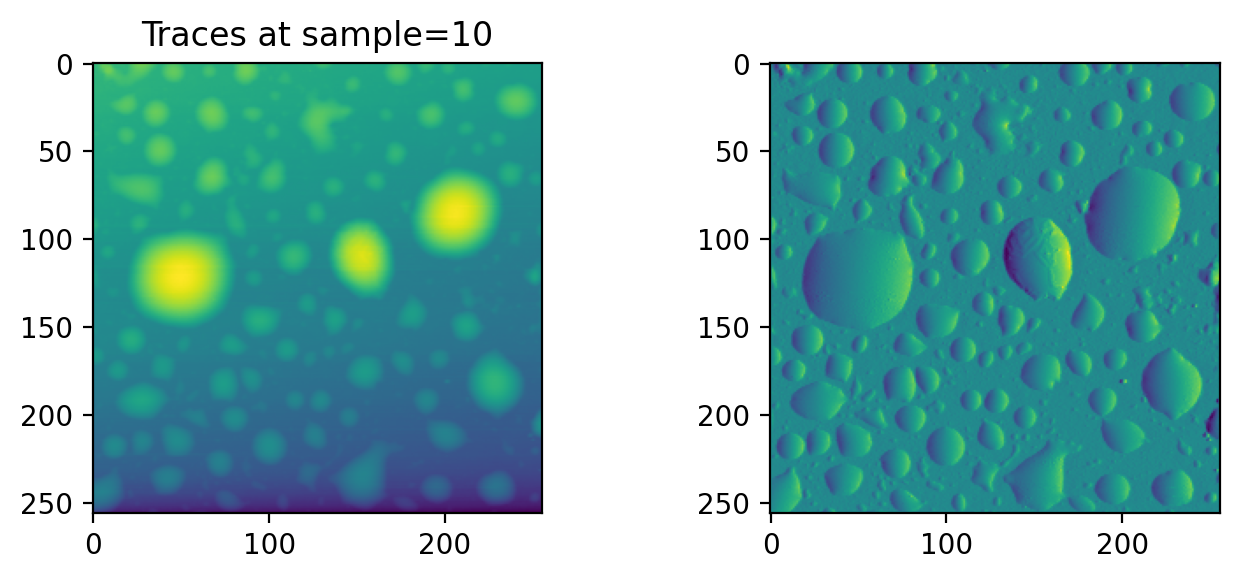

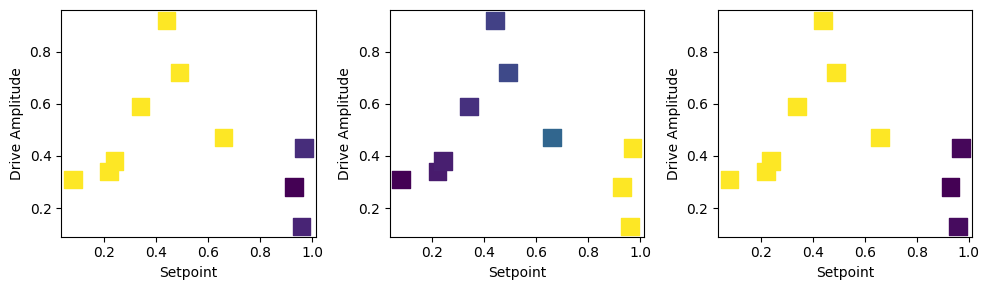

In [27]:
exp_mobo.generate_seed_mobo(num=10, repeat=1)

In [28]:
exp_mobo.param['X_measured_array_seed'], exp_mobo.param['y_measured_array_seed']

(array([[0.58585859, 0.33333333],
        [0.12121212, 0.95959596],
        [0.91919192, 0.43434343],
        [0.71717172, 0.48484848],
        [0.3030303 , 0.07070707],
        [0.33333333, 0.21212121],
        [0.27272727, 0.92929293],
        [0.37373737, 0.23232323],
        [0.42424242, 0.96969697],
        [0.46464646, 0.65656566]]),
 array([[-1.29549286e+00, -2.86705696e+03, -1.02911061e+00],
        [-1.26807390e+01, -2.76865881e+01, -2.52347452e+00],
        [-1.29549286e+00, -2.68396834e+03, -1.02911061e+00],
        [-1.29549286e+00, -2.58900787e+03, -1.02911061e+00],
        [-1.29549286e+00, -3.31896170e+03, -1.02911061e+00],
        [-1.29549286e+00, -3.07849135e+03, -1.02911061e+00],
        [-1.39456657e+01, -2.76727140e+01, -2.56609443e+00],
        [-1.29549286e+00, -3.04370574e+03, -1.02911061e+00],
        [-1.23454909e+01, -2.76886512e+01, -2.53976517e+00],
        [-1.29549286e+00, -2.23922321e+03, -1.02911061e+00]]))

## Run the active learning experiments

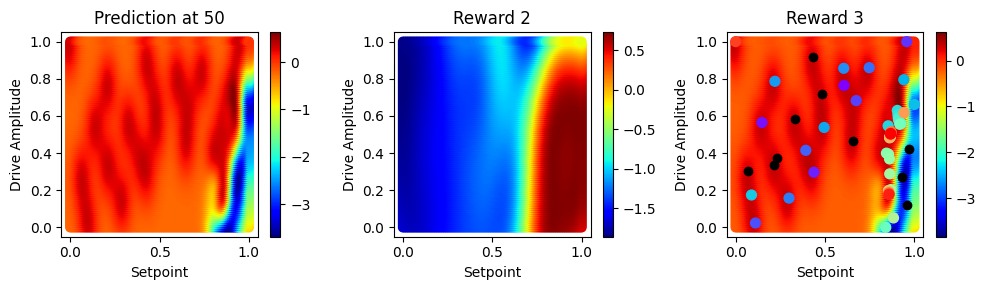

In [29]:
exp_mobo.run_mobo(num_steps=50, acquisition='qNEHVI', repeat=1)

In [30]:
# save the exp.param with pickle
import pickle
pname = 'mobo_qEHVI.pkl'
# Save the dictionary to a file
with open("{}".format(pname), "wb") as file:  # Use "wb" mode to write in binary format
    pickle.dump(exp_mobo.param, file)

# # Load the dictionary from a file
# with open("mobo_qNEHVI.pkl", "rb") as file:  # Use "rb" mode to read in binary format
#     mobo_qNEHVI = pickle.load(file)

In [31]:
rewards.shape

(100, 100, 3)

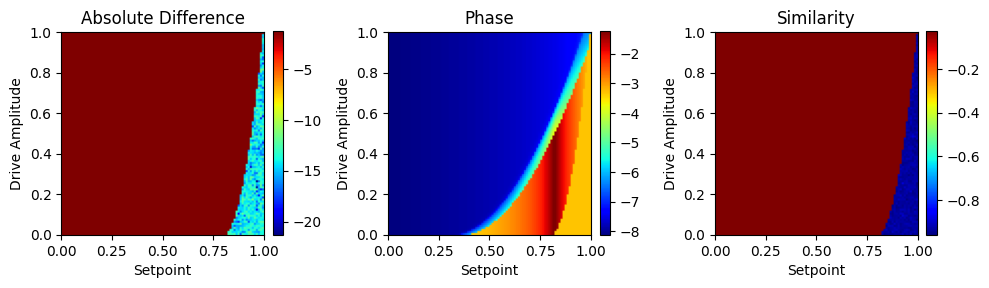

In [32]:
# This is the ground-truth reward distributions for comparison
titles = ['Absolute Difference', 'Phase', 'Similarity']
fig,ax=plt.subplots(1,3,figsize=[10,3])
im1 = ax[0].imshow(rewards[:,:,0], extent=[0,1,0,1], origin='lower', cmap='jet')
im2 = ax[1].imshow(-np.log(-rewards[:,:,1]), extent=[0,1,0,1], origin='lower', cmap='jet')
im3 = ax[2].imshow(-np.log(-rewards[:,:,2]), extent=[0,1,0,1], origin='lower', cmap='jet')

ims = [im1, im2, im3]

for i in range(3):
    plt.colorbar(ims[i], ax=ax[i], fraction=0.046, pad=0.04)
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Setpoint')
    ax[i].set_ylabel('Drive Amplitude')

plt.tight_layout()

# plt.savefig('output/rewards separate ground truth.png', dpi=400, pad_inches=0.1, bbox_inches='tight')

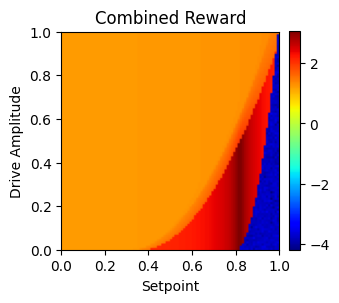

In [34]:
# Here is the ground-truth for the single combined reward
reward_single = -np.log((-rewards[:,:,0]) * np.log(-rewards[:,:,1])* np.log(-rewards[:,:,2]))
plt.figure(figsize=[3.5, 3.5])
plt.imshow(reward_single, extent=[0,1,0,1], origin='lower', cmap='jet')
plt.colorbar( fraction=0.046, pad=0.04)
plt.title('Combined Reward')
plt.xlabel('Setpoint')
plt.ylabel('Drive Amplitude')
plt.tight_layout()
# plt.savefig('output/single combined ground truth.png', dpi=400, pad_inches=0.1, bbox_inches='tight')


# Compare with single-task GP

## Define functions

In [35]:
def generate_seed(self, num=10, repeat=1):

    np.random.seed(35)
    X = self.param['X_array']

    idx = np.random.randint(0, len(X), num)

    X_measured = X[idx]
    X_exp_measured = self.param['X_exp'][idx]

    y_measured = np.zeros(len(idx))

    mask = np.ones(len(idx))

    indices_measured = idx
    indices_unmeasured = np.delete(np.arange(len(X)), idx, 0)

    self.update_param('num_seed', num)
    self.update_param('idx', idx)
    self.update_param('indices_unmeasured_seed', indices_unmeasured)
    self.update_param('indices_measured_seed', indices_measured)

    for i in range(num):
        if len(X_measured[i]) == 2:
            drive, setpoint = X_measured[i]
            i_gain = None
        else:
            drive, setpoint, i_gain = X_measured[i]

        y_measured[i], traces = self.measure_with_noise_single(drive=drive, setpoint=setpoint, i_gain=i_gain, repeat=repeat, trace=True)

        plot_seed(traces, i)

        self.update_param(key='index', value=(i+1) * repeat)

    plt.figure(figsize=[4,3])
    plt.scatter(X_exp_measured[:, 1], X_exp_measured[:, 0], c=y_measured, s=160, marker='s')
    plt.xlabel('Setpoint')
    plt.ylabel('Drive Amplitude')
    plt.tight_layout()

    X_unmeasured = np.delete(X, idx, axis=0)
    X_exp_unmeasured = np.delete(self.param['X_exp'], idx, axis=0)

    y_measured = np.asarray(y_measured, dtype=np.float64)

    self.update_param('X_measured_array_seed', X_measured)

    self.update_param('X_exp_measured', X_exp_measured)
    self.update_param('X_exp_unmeasured', X_exp_unmeasured)

    self.update_param('X_exp_measured_seed', X_exp_measured)
    self.update_param('X_exp_unmeasured_seed', X_exp_unmeasured)

    self.update_param('X_unmeasured_array_seed', X_unmeasured)
    self.update_param('y_measured_array_seed', y_measured)

    self.update_param('X_measured_tensor_seed', torch.from_numpy(X_measured))
    self.update_param('X_unmeasured_tensor_seed', torch.from_numpy(X_unmeasured))
    self.update_param('y_measured_tensor_seed', torch.from_numpy(y_measured))

def plot_seed(traces, i):

    clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=200)

    h1, h2, ph1, ph2 = traces[0]

    ax[0].imshow(h1)
    ax[1].imshow(ph1)
    ax[0].set_title("Traces at sample={}".format(i+1))
    # ax[0].plot(h1)
    # ax[0].plot(h2)
    # ax[0].set_xlabel('Pixels')
    # ax[0].set_ylabel('Height (nm)')
    # ax[0].set_title("Traces at sample={}".format(i+1))
    # ax[1].plot(ph1)
    # ax[1].plot(ph2)
    # ax[1].axhline(90, linestyle='--', color='r')
    # ax[1].set_xlabel('Pixels')
    # ax[1].set_ylabel('Phase')
    # ax[1].set_title("Phases")
    # plt.tight_layout()
    plt.show()

def step(self, acquisition='EI', beta=4):

    gp_model = SingleTaskGP(self.param['X_measured_tensor'], torch.unsqueeze(self.param['y_measured_tensor'], dim=-1))

    # Fit GP model
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)

    fit_gpytorch_mll(mll)

    # Predict on unmeasured data
    gp_model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        posterior = gp_model(self.param['X_unmeasured_tensor'])
        # For visualization or further processing, you can obtain mean and variance
        y_pred = posterior.mean
        y_sampled = posterior.variance.sqrt()

    # Compute acquisition function (Expected Improvement here)

    if acquisition=='UCB':
        UCB = UpperConfidenceBound(model=gp_model, beta=beta)
        acq_values = UCB(self.param['X_unmeasured_tensor'].unsqueeze(-2))
    elif acquisition=='EI':
        # EI = ExpectedImprovement(model=gp_model, best_f=y_measured.max(), maximize=True)
        EI = LogExpectedImprovement(model=gp_model, best_f=self.param['y_measured_tensor'].max(), maximize=True)
        acq_values = EI(self.param['X_unmeasured_tensor'].unsqueeze(-2))
    else:
        return 0

    self.update_param('acq_tensor', acq_values)
    self.update_param('y_pred_tensor', y_pred)
    self.update_param('y_sampled_tensor', y_sampled)

    self.update_param('acq_array', acq_values.detach().numpy())
    self.update_param('y_pred_array', y_pred.detach().numpy())
    self.update_param('y_sampled_array', y_sampled.detach().numpy())

# Active learning

def run_BO_loss(self, mask=None, fresh=True, num_steps=30, repeat=1,
           show=True, acquisition='EI', beta=4, save=None):

    import warnings

    warnings.filterwarnings('ignore')

    # waves = np.zeros([num_steps, repeat, 8, 256])

    if fresh:
        self.update_param('X_measured_array', self.param['X_measured_array_seed'])
        self.update_param('X_unmeasured_array', self.param['X_unmeasured_array_seed'])
        self.update_param('y_measured_array', self.param['y_measured_array_seed'])

        self.update_param('X_exp_measured', self.param['X_exp_measured_seed'])
        self.update_param('X_exp_unmeasured', self.param['X_exp_unmeasured_seed'])

        self.update_param('X_measured_tensor', self.param['X_measured_tensor_seed'])
        self.update_param('X_unmeasured_tensor', self.param['X_unmeasured_tensor_seed'])
        self.update_param('y_measured_tensor', self.param['y_measured_tensor_seed'])

        self.update_param('indices_measured', self.param['indices_measured_seed'])
        self.update_param('indices_unmeasured', self.param['indices_unmeasured_seed'])

    y_measured = self.param['y_measured_tensor']
    X_measured = self.param['X_measured_tensor']
    X_unmeasured = self.param['X_unmeasured_tensor']

    X_exp_measured = self.param['X_exp_measured']
    X_exp_unmeasured = self.param['X_exp_unmeasured']

    loss = []

    rewards_all = []

    scan_opt = []

    param_opt = []

    for e in range(num_steps):

        self.step(acquisition=acquisition, beta=beta)

        if mask is None:
            acq_masked = self.param['acq_array']
        else:
            acq = self.param['acq_array']
            acq_masked = (acq-acq.min()) * mask.flatten()[self.param['indices_unmeasured']]

        self.update_param('acq_masked', acq_masked)

        next_idx = acq_masked.argmax()
        next_point_exp = X_exp_unmeasured[next_idx]
        next_point = X_unmeasured[next_idx]

        if len(next_point_exp) == 2:
            v_ac, setpoint = next_point_exp
            i_gain = None
        else:
            v_ac, setpoint, i_gain = next_point_exp
        if not e:
            next_measure, traces = self.measure_with_noise_single(drive=v_ac, setpoint=setpoint, i_gain=i_gain, repeat=repeat, trace=True)
        else:
            next_measure, traces = self.measure_with_noise_single(drive=v_ac, setpoint=setpoint, i_gain=i_gain, repeat=repeat, trace=True)
        # waves[e] = w

        if show is True:
            self.plot_bo(title='Prediction at {}'.format(e+1))

        next_point = torch.tensor(next_point, dtype=torch.float64)
        next_measure = torch.tensor([next_measure], dtype=torch.float64)

        y_measured = torch.cat((y_measured, next_measure), axis=0)

        X_measured = torch.cat((X_measured, next_point.unsqueeze(-2)), axis=0)

        X_unmeasured = torch.tensor(np.delete(X_unmeasured, next_idx, axis=0), dtype=torch.float64)

        X_exp_measured =  np.concatenate((self.param['X_exp_measured'], [next_point_exp]), axis=0)
        X_exp_unmeasured = np.delete(X_exp_unmeasured, next_idx, axis=0)
        self.update_param('X_exp_measured', X_exp_measured)
        self.update_param('X_exp_unmeasured', X_exp_unmeasured)

        self.update_param('X_measured_tensor', X_measured)
        self.update_param('X_unmeasured_tensor', X_unmeasured)
        self.update_param('y_measured_tensor', y_measured)

        self.update_param('X_measured_array', X_measured.detach().numpy())
        self.update_param('X_unmeasured_array', X_unmeasured.detach().numpy())
        self.update_param('y_measured_array', y_measured.detach().numpy())

        self.update_param('indices_measured', np.concatenate((self.param['indices_measured'], [next_idx])))
        self.update_param('indices_unmeasured', np.delete(self.param['indices_unmeasured'], next_idx))

        y_pred = self.train_BO_loss(acquisition=acquisition, beta=beta)

        index_min = y_pred.argmax()

        v_ac_op = self.param['X_exp'][index_min][0]
        setpoint_op = self.param['X_exp'][index_min][1]

        img_op, phase_op, *_ = scan(image=self.param['image'], kernel=self.param['kernel'], drive=v_ac_op, setpoint=setpoint_op, phase=True)

        scan_opt.append([img_op, phase_op])
        param_opt.append([v_ac_op, setpoint_op])
        rewards_all.append(y_pred)

        loss.append(np.abs(img_op-self.param['image']).mean())

    self.update_param('scan_opt', scan_opt)
    self.update_param('param_opt', param_opt)
    self.update_param('loss', loss)
    self.update_param('rewards_all', np.array(rewards_all))

def plot_bo(self, title=''):

    X_measured = self.param['X_exp_measured']
    X_unmeasured = self.param['X_exp_unmeasured']

    y_measured = self.param['y_measured_array']
    acq = self.param['acq_masked']
    y_pred = self.param['y_pred_array']
    y_sampled = self.param['y_sampled_array']
    num_seed = self.param['num_seed']

    clear_output(wait=True)
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    im1 = ax[0].scatter(X_unmeasured[:, 1], X_unmeasured[:, 0], c=y_pred, s=40, cmap='jet')
    ax[0].set_title("{}".format(title))

    im2 = ax[1].scatter(X_unmeasured[:, 1], X_unmeasured[:, 0], c=acq, s=40, cmap='jet')
    ax[1].set_title("Acquisition")

    ax[2].scatter(X_unmeasured[:, 1], X_unmeasured[:, 0], c=y_pred, cmap='gray')
    ax[2].scatter(X_measured[:num_seed,1], X_measured[:num_seed,0], c = 'k')

    im3 = ax[2].scatter(X_measured[num_seed:, 1], X_measured[num_seed:, 0], marker='o', s=50,
                        c = np.arange(len(X_measured)-num_seed), cmap = 'rainbow')
    ax[2].set_title("BO trajectory")

    for axis in ax:
        axis.set_xlabel('Setpoint')
        axis.set_ylabel('Drive Amplitude')

    plt.colorbar(im1, ax=ax[0])
    plt.colorbar(im2, ax=ax[1])
    plt.colorbar(im3, ax=ax[2])
    plt.tight_layout()
    plt.show()

# Visualize the training result
def train_BO_loss(self, acquisition='EI', beta=4):

    X = self.param['X_tensor']
    X_measured = self.param['X_measured_tensor']
    y_measured = self.param['y_measured_tensor']

    gp_model = SingleTaskGP(X_measured, torch.unsqueeze(y_measured, dim=-1))
    # Fit GP model
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)

    fit_gpytorch_mll(mll)

    # Predict on unmeasured data
    gp_model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        posterior = gp_model(X)
        # For visualization or further processing, you can obtain mean and variance
        y_pred = posterior.mean
        y_sampled = posterior.variance.sqrt()

    if acquisition=='UCB':
        UCB = UpperConfidenceBound(model=gp_model, beta=beta)
        acq_values = UCB(X.unsqueeze(-2))
    elif acquisition=='EI':
        EI = ExpectedImprovement(model=gp_model, best_f=y_measured.max(), maximize=True)
        acq_values = EI(X.unsqueeze(-2))
    else:
        return 0

    return y_pred.detach().numpy()

    # self.update_param('acq_tensor', acq_values)
    # self.update_param('y_pred_tensor', y_pred)
    # self.update_param('y_sampled_tensor', y_sampled)

    # self.update_param('acq_array', acq_values.detach().numpy())
    # self.update_param('y_pred_array', y_pred.detach().numpy())
    # self.update_param('y_sampled_array', y_sampled.detach().numpy())


## Setup problems

In [36]:
exp_bo = Experiment()

# exp.add_func(reward) # this is the reward for the scan lines
exp_bo.add_func(generate_seed)
exp_bo.add_func(measure_with_noise_single)

exp_bo.add_func(step)
exp_bo.add_func(plot_bo)
exp_bo.add_func(run_BO_loss)
exp_bo.add_func(train_BO_loss)
# exp.add_func(acq_mask)

In [37]:
exp_bo.update_param('image', img)
exp_bo.update_param('kernel', kernel_1)

for ix in tkwargs:
    exp_bo.update_param(ix, tkwargs[ix])

# v_ac in V
x1_min = 0.01
x1_max = 1
num1 = 100

# setpoint
x2_min = 0.01
x2_max = 1
num2 = 100

# Make the grid for exploration

# exp.update_param('factor', factor)
exp_bo.update_param('offset', 0)
exp_bo.update_param('num1', num1)
exp_bo.update_param('num2', num2)
exp_bo.update_param('index', 0)

x1 = np.linspace(x1_min, x1_max, num=num1)
x2 = np.linspace(x2_min, x2_max, num=num2)

x1_norm = np.linspace(0, 1, num=num1)
x2_norm = np.linspace(0, 1, num=num2)

x_exp = []

for i in range(len(x1)):
    for j in range(len(x2)):
        x_exp.append([x1[i], x2[j]])

exp_bo.update_param('X_exp', np.asarray(x_exp, dtype=np.float64))

x = []

for i in range(len(x1_norm)):
    for j in range(len(x2_norm)):
        x.append([x1_norm[i], x2_norm[j]])

x = np.asarray(x, dtype=np.float64)
X = torch.from_numpy(x).to(tkwargs['device'])
# X = np.copy(x)
# exp.update_param('X', x)
exp_bo.update_param('X_array', x)
exp_bo.update_param('X_tensor', X)

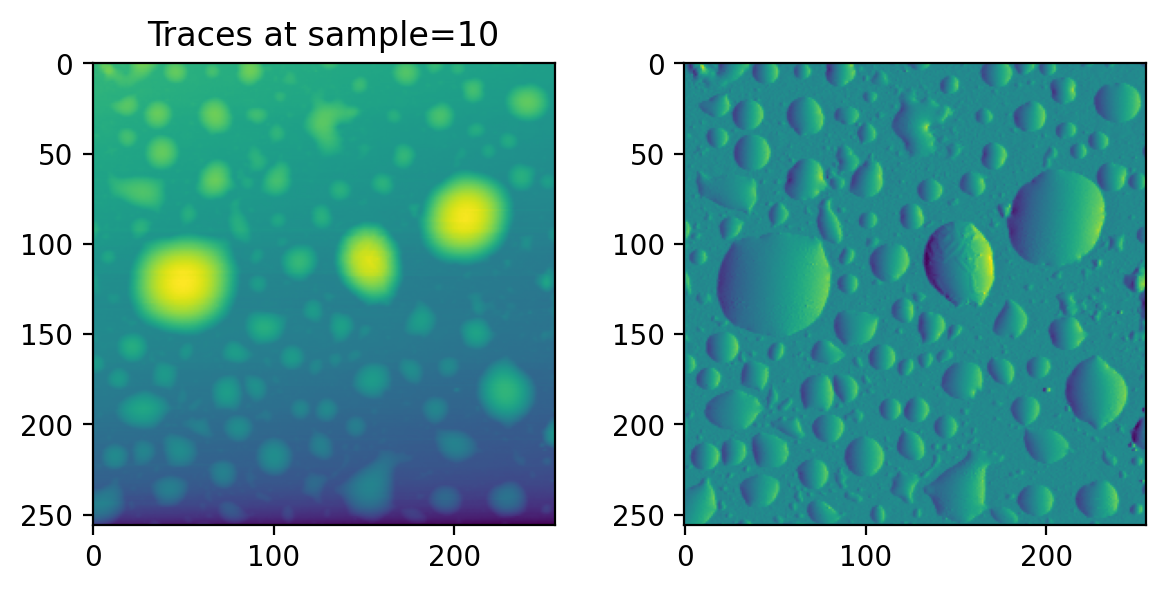

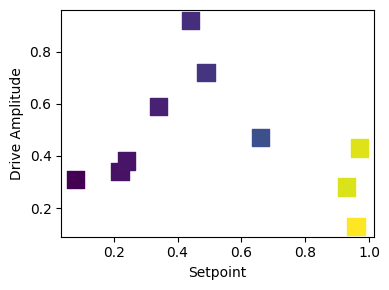

In [38]:
exp_bo.generate_seed(num=10, repeat=1)

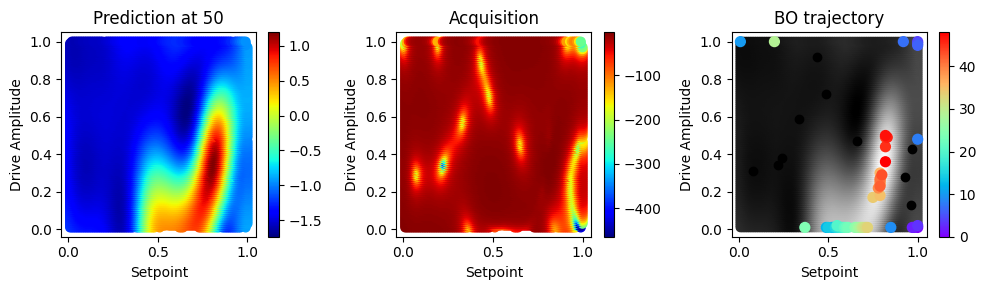

In [39]:
exp_bo.run_BO_loss(num_steps=50, repeat=1)

In [41]:
exp_bo.update_param('predicts', exp_bo.param['rewards_all'])

In [42]:
# save the exp.param with pickle
import pickle

pname = 'bo_EI'

# Save the dictionary to a file
with open("{}.pkl".format(pname), "wb") as file:  # Use "wb" mode to write in binary format
    pickle.dump(exp_bo.param, file)

# # Load the dictionary from a file
# with open("{}.pkl".format(pname), "rb") as file:  # Use "rb" mode to read in binary format
#     mobo_qNEHVI = pickle.load(file)

# Compare the results of BO and MOBO

## Define plot functions

In [43]:
# import aespm as ae
# import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
# plt.rcParams['animation.ffmpeg_path'] = r"C:\Program Files\ffmpeg\bin\ffmpeg.exe"

In [44]:
## Load the data
import pickle
def load_pickle(fname):
    with open(fname, "rb") as file:  # Use "rb" mode to read in binary format
        output = pickle.load(file)
    return output

In [45]:
# param_bo = load_pickle('bo_EI.pkl')
# param_mobo_qNEHVI = load_pickle('mobo_qNEHVI_new.pkl')
# # param_mobo_qEHVI_new = load_pickle('mobo_qEHVI_new.pkl')
param_bo = exp_bo.param
param_mobo_qNEHVI = exp_mobo.param

In [46]:
def plot_BO_steps(param, step, mobo=True, fig=False):

    X = param['X_array']

    num_seed = param['num_seed']
    end = num_seed + step

    pred = param['predicts'][step]
    X_measured = param['X_measured_tensor'].detach().numpy()

    # reward_single = -np.log((-rewards[:,:,0]) * np.log(-rewards[:,:,1])* np.log(-rewards[:,:,2]))
    # reward_single = -np.log((-pred[0]) * np.log(-pred[1])* np.log(-pred[2]))


    if mobo is True:
        # Create a figure
        if fig == False:
            fig = plt.figure(figsize=(13, 3))

        # Create a GridSpec with 4 rows and 5 columns
        gs = gridspec.GridSpec(1, 4)

        ax = []

        for j in range(4):
            ax1 = fig.add_subplot(gs[0, j])
        #     ax.set_aspect('equal')
            ax.append(ax1)

        im1 = ax[0].scatter(X[:, 1], X[:, 0], c=pred[0], s=40, cmap='jet')
        ax[0].set_title("Height Difference")

        im2 = ax[1].scatter(X[:, 1], X[:, 0], c=pred[1], s=40, cmap='jet')
        ax[1].set_title("Phase (step={})".format(step))

        im3 = ax[2].scatter(X[:, 1], X[:, 0], c=pred[2], s=40, cmap='jet')

        ax[2].set_title("Similarity")

        # im4 = ax[3].scatter(X[:, 1], X[:, 0], c=reward_single, s=40, cmap='gray_r')

        ax[3].set_title("Trjactory")
        ax[3].scatter(X_measured[:num_seed,1], X_measured[:num_seed,0], c = 'k')
        im4 = ax[3].scatter(X_measured[num_seed:end, 1], X_measured[num_seed:end, 0], marker='o', s=50,
                            c = np.arange(step), cmap = 'rainbow')

        for axis in ax:
            axis.set_xlabel('Setpoint')
            axis.set_ylabel('Drive Amplitude')

        plt.colorbar(im1, ax=ax[0])
        plt.colorbar(im2, ax=ax[1])
        plt.colorbar(im3, ax=ax[2])
        plt.colorbar(im4, ax=ax[3])

        plt.tight_layout()
    else:
        # Create a figure
        if fig == False:
            fig = plt.figure(figsize=(7, 3))

        # Create a GridSpec with 4 rows and 5 columns
        gs = gridspec.GridSpec(1, 2)

        ax = []

        for j in range(2):
            ax1 = fig.add_subplot(gs[0, j])
        #     ax.set_aspect('equal')
            ax.append(ax1)

        im1 = ax[0].scatter(X[:, 1], X[:, 0], c=pred, s=40, cmap='jet')
        ax[0].set_title("Combined Reward")

        ax[1].set_title("Trjactory at {}".format(step))
        ax[1].scatter(X_measured[:num_seed,1], X_measured[:num_seed,0], c = 'k')
        im2 = ax[1].scatter(X_measured[num_seed:end, 1], X_measured[num_seed:end, 0], marker='o', s=50,
                            c = np.arange(step), cmap = 'rainbow')

        for axis in ax:
            axis.set_xlabel('Setpoint')
            axis.set_ylabel('Drive Amplitude')

        plt.colorbar(im1, ax=ax[0])
        plt.colorbar(im2, ax=ax[1])
        plt.tight_layout()

In [ ]:
# plot_BO_steps(param_mobo_qEHVI, step=19)
# # plt.savefig('qHEVI training results new.png', dpi=400, bbox_inches='tight', pad_inches=0.1)

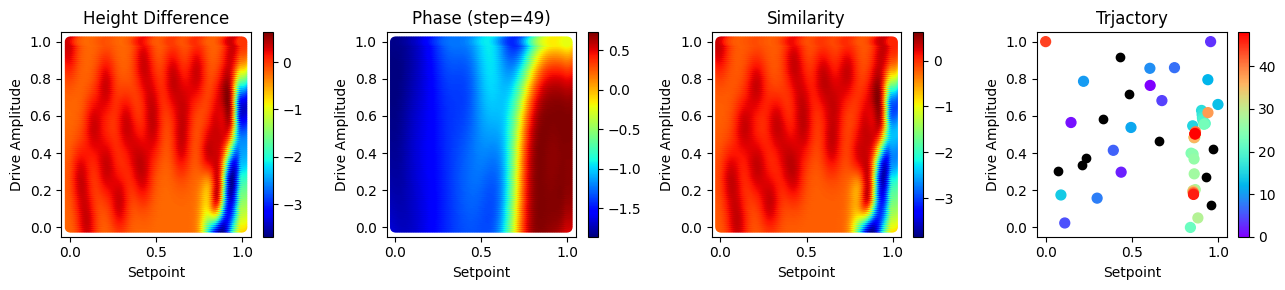

In [48]:
plot_BO_steps(param_mobo_qNEHVI, step=49)
# plt.savefig('output/qNEHVI training results new.png', dpi=400, bbox_inches='tight', pad_inches=0.1)

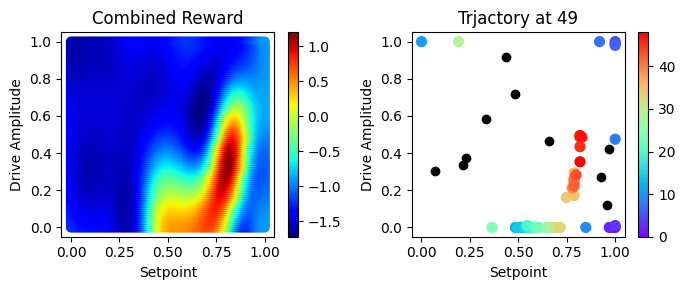

In [49]:
plot_BO_steps(param_bo, mobo=False, step=49)
# plt.savefig('output/bo EI training results.png', dpi=400, bbox_inches='tight', pad_inches=0.1)

In [50]:
# def write_animation(name, param, mobo=True, frames=100):
#     if mobo is True:
#         fig = plt.figure(figsize=(13, 3))
#     else:
#         fig = plt.figure(figsize=(7, 3))

#     def update(step):
#         plt.clf()
#         plot_BO_steps(param, step=step, mobo=mobo,fig=fig)

#     # Create the animation
#     ani = animation.FuncAnimation(fig, update, frames=frames, repeat=False)

#     # Save the animation
#     ani.save('{}.mp4'.format(name), writer='ffmpeg', dpi=200, bitrate=1e5, fps=1)

In [51]:
# write_animation(r'output\bo_EI', param_bo, mobo=False)

In [52]:
# write_animation(r'output\mobo_qNEHVI_new', param_mobo_qNEHVI_new, mobo=True)

In [53]:
# write_animation(r'output\mobo_qEHVI_new', param_mobo_qEHVI_new, mobo=True)

## Benchmarking the optimization precison

In [54]:
rewards = np.load('rewards_multiple2.npy')

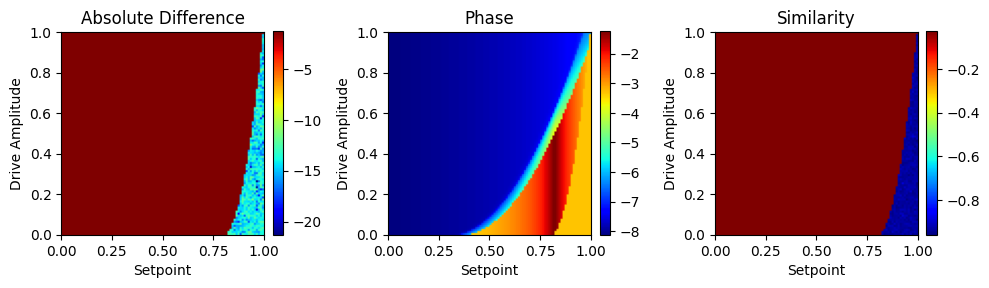

In [55]:
titles = ['Absolute Difference', 'Phase', 'Similarity']
fig,ax=plt.subplots(1,3,figsize=[10,3])
im1 = ax[0].imshow(rewards[:,:,0], extent=[0,1,0,1], origin='lower', cmap='jet')
im2 = ax[1].imshow(-np.log(-rewards[:,:,1]), extent=[0,1,0,1], origin='lower', cmap='jet')
im3 = ax[2].imshow(-np.log(-rewards[:,:,2]), extent=[0,1,0,1], origin='lower', cmap='jet')

ims = [im1, im2, im3]

for i in range(3):
    plt.colorbar(ims[i], ax=ax[i], fraction=0.046, pad=0.04)
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Setpoint')
    ax[i].set_ylabel('Drive Amplitude')

plt.tight_layout()

# plt.savefig('output/rewards separate ground truth.png', dpi=400, pad_inches=0.1, bbox_inches='tight')

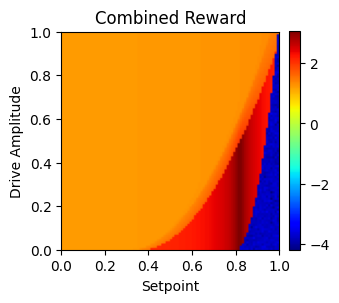

In [56]:
reward_single = -np.log((-rewards[:,:,0]) * np.log(-rewards[:,:,1])* np.log(-rewards[:,:,2]))
plt.figure(figsize=[3.5, 3.5])
plt.imshow(reward_single, extent=[0,1,0,1], origin='lower', cmap='jet')
plt.colorbar( fraction=0.046, pad=0.04)
plt.title('Combined Reward')
plt.xlabel('Setpoint')
plt.ylabel('Drive Amplitude')
plt.tight_layout()
# plt.savefig('output/single combined ground truth.png', dpi=400, pad_inches=0.1, bbox_inches='tight')


In [57]:
x1 = np.linspace(0.01,1,100)
x2 = np.linspace(0.01,1,100)

index = np.where(np.abs(reward_single - np.max(reward_single)) < 0.1)
reward_pts = []

for i in range(len(index[0])):
    reward_pts.append([x1[index[0][i]], x2[index[1][i]]])

reward_pts = np.array(reward_pts)

In [58]:
def compute_error(param, num=100):
    tp1 = np.array(param['param_opt'])

    distance1 = np.zeros(len(tp1))

    for i in range(num):
        # Compute squared distances between A and all points in B
        distances_squared = np.sum((reward_pts - tp1[i]) ** 2, axis=1)

        # Find the minimum distance
        distance1[i] = np.sqrt(np.min(distances_squared))

    return distance1

In [59]:
distance_bo = compute_error(param_bo, num=50)
distance_mobo_qNEHVI = compute_error(param_mobo_qNEHVI, num=50)
# distance_mobo_qEHVI = compute_error(param_mobo_qEHVI, num=100)


Text(0, 0.5, 'Optimization Error')

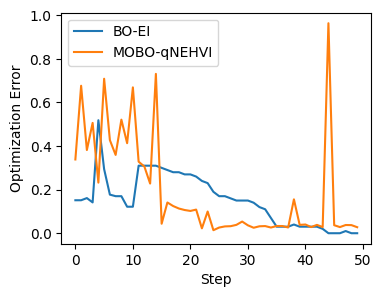

In [60]:
plt.figure(figsize=[4,3])
plt.plot(distance_bo, label='BO-EI')
# plt.plot(distance_mobo_qEHVI, label='MOBO-qEHVI')
plt.plot(distance_mobo_qNEHVI, label='MOBO-qNEHVI')
plt.legend()
plt.xlabel('Step')
plt.ylabel('Optimization Error')

# plt.savefig('output/error comparison.png', dpi=400, bbox_inches='tight', pad_inches=0.1)


## Pareto

In [61]:
param_bo = exp_bo.param
param_mobo_qNEHVI = exp_mobo.param

y_measured = param_mobo_qNEHVI['y_measured_array']


In [62]:
reward_pts.shape

(98, 2)

In [64]:
index = np.where(np.abs(reward_single - np.max(reward_single)) < 0.1)

rew1 = rewards[index][:, 0]
rew2 = rewards[index][:, 1]
rew3 = rewards[index][:, 2]


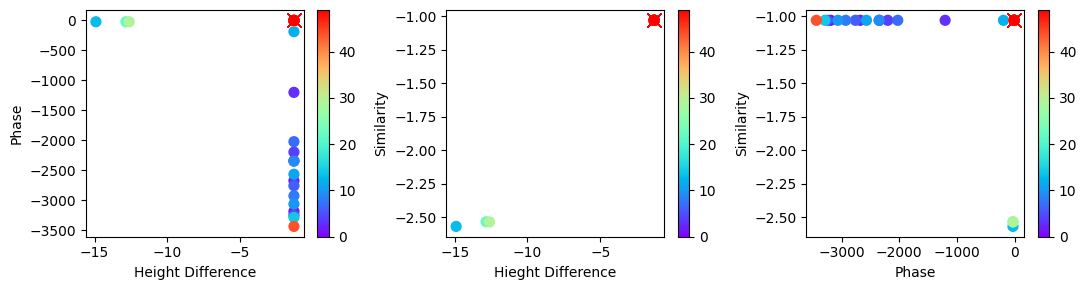

In [66]:
tp = y_measured

xlabels = ['Height Difference', 'Hieght Difference', 'Phase']
ylabels = ['Phase', 'Similarity', 'Similarity']

num_step = 50
num_seed = 10
fig, ax = plt.subplots(1,3,figsize=[11,3])
im1 = ax[0].scatter(tp[num_seed:, 0], tp[num_seed:, 1], marker='o', s=50,
         c = np.arange(num_step), cmap = 'rainbow')
ax[0].plot(rew1, rew2, 'rx', ms=10)

im2 = ax[1].scatter(tp[num_seed:, 0], tp[num_seed:, 2], marker='o', s=50,
         c = np.arange(num_step), cmap = 'rainbow')
ax[1].plot(rew1, rew3, 'rx', ms=10)

im3 = ax[2].scatter(tp[num_seed:, 1], tp[num_seed:, 2], marker='o', s=50,
         c = np.arange(num_step), cmap = 'rainbow')
ax[2].plot(rew2, rew3, 'rx', ms=10)

for i in range(3):
    ax[i].set_xlabel('{}'.format(xlabels[i]))
    ax[i].set_ylabel('{}'.format(ylabels[i]))

plt.colorbar(im1, ax=ax[0])
plt.colorbar(im2, ax=ax[1])
plt.colorbar(im3, ax=ax[2])

plt.tight_layout()

# plt.savefig('output/qEHVI pareto.png', dpi=400, bbox_inches='tight', pad_inches=0.1)


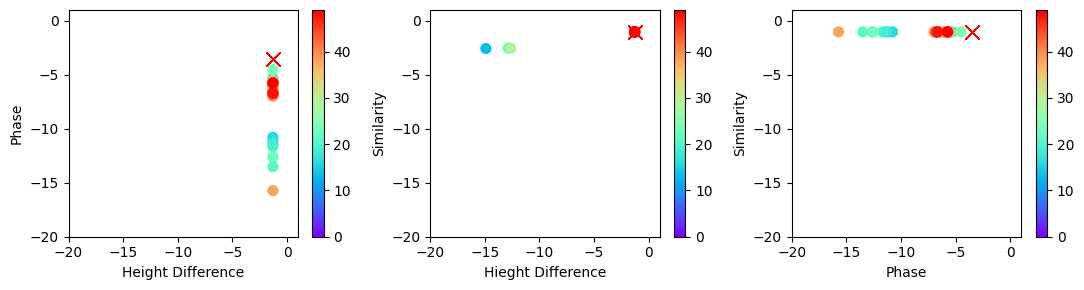

In [67]:
tp = y_measured

xlabels = ['Height Difference', 'Hieght Difference', 'Phase']
ylabels = ['Phase', 'Similarity', 'Similarity']

num_step = 50
num_seed = 10
fig, ax = plt.subplots(1,3,figsize=[11,3])
im1 = ax[0].scatter(tp[num_seed:, 0], tp[num_seed:, 1], marker='o', s=50,
         c = np.arange(num_step), cmap = 'rainbow')
ax[0].plot(rew1, rew2, 'rx', ms=10)

im2 = ax[1].scatter(tp[num_seed:, 0], tp[num_seed:, 2], marker='o', s=50,
         c = np.arange(num_step), cmap = 'rainbow')
ax[1].plot(rew1, rew3, 'rx', ms=10)

im3 = ax[2].scatter(tp[num_seed:, 1], tp[num_seed:, 2], marker='o', s=50,
         c = np.arange(num_step), cmap = 'rainbow')
ax[2].plot(rew2, rew3, 'rx', ms=10)

for i in range(3):
    ax[i].set_xlabel('{}'.format(xlabels[i]))
    ax[i].set_ylabel('{}'.format(ylabels[i]))
    ax[i].set_xlim(-20, 1)
    ax[i].set_ylim(-20, 1)


plt.colorbar(im1, ax=ax[0])
plt.colorbar(im2, ax=ax[1])
plt.colorbar(im3, ax=ax[2])

plt.tight_layout()

# plt.savefig('output/qEHVI pareto zoomed in.png', dpi=400, bbox_inches='tight', pad_inches=0.1)


In [69]:
# tp = y_measured

# xlabels = ['Height Difference', 'Hieght Difference', 'Phase']
# ylabels = ['Phase', 'Similarity', 'Similarity']

# num_step = 50
# num_seed = 10
# fig, ax = plt.subplots(1,3,figsize=[11,3])
# im1 = ax[0].scatter(tp[num_seed:, 0], tp[num_seed:, 1], marker='o', s=50,
#          c = np.arange(num_step), cmap = 'rainbow')
# ax[0].plot(rew1, rew2, 'rx', ms=10)

# im2 = ax[1].scatter(tp[num_seed:, 0], tp[num_seed:, 2], marker='o', s=50,
#          c = np.arange(num_step), cmap = 'rainbow')
# ax[1].plot(rew1, rew3, 'rx', ms=10)

# im3 = ax[2].scatter(tp[num_seed:, 1], tp[num_seed:, 2], marker='o', s=50,
#          c = np.arange(num_step), cmap = 'rainbow')
# ax[2].plot(rew2, rew3, 'rx', ms=10)

# for i in range(3):
#     ax[i].set_xlabel('{}'.format(xlabels[i]))
#     ax[i].set_ylabel('{}'.format(ylabels[i]))

# plt.colorbar(im1, ax=ax[0])
# plt.colorbar(im2, ax=ax[1])
# plt.colorbar(im3, ax=ax[2])

# plt.tight_layout()

# # plt.savefig('output/qNEHVI pareto.png', dpi=400, bbox_inches='tight', pad_inches=0.1)


In [70]:
# tp = obj_qNEHVI

# xlabels = ['Height Difference', 'Hieght Difference', 'Phase']
# ylabels = ['Phase', 'Similarity', 'Similarity']

# num_step = 20
# num_seed = 8
# fig, ax = plt.subplots(1,3,figsize=[11,3])
# im1 = ax[0].scatter(tp[num_seed:, 0], tp[num_seed:, 1], marker='o', s=50,
#          c = np.arange(num_step), cmap = 'rainbow')
# ax[0].plot(rew1, rew2, 'rx', ms=10)

# im2 = ax[1].scatter(tp[num_seed:, 0], tp[num_seed:, 2], marker='o', s=50,
#          c = np.arange(num_step), cmap = 'rainbow')
# ax[1].plot(rew1, rew3, 'rx', ms=10)

# im3 = ax[2].scatter(tp[num_seed:, 1], tp[num_seed:, 2], marker='o', s=50,
#          c = np.arange(num_step), cmap = 'rainbow')
# ax[2].plot(rew2, rew3, 'rx', ms=10)

# for i in range(3):
#     ax[i].set_xlabel('{}'.format(xlabels[i]))
#     ax[i].set_ylabel('{}'.format(ylabels[i]))
#     ax[i].set_xlim(-20, 1)
#     ax[i].set_ylim(-20, 1)


# plt.colorbar(im1, ax=ax[0])
# plt.colorbar(im2, ax=ax[1])
# plt.colorbar(im3, ax=ax[2])

# plt.tight_layout()

# # plt.savefig('output/qNEHVI pareto zoomed in.png', dpi=400, bbox_inches='tight', pad_inches=0.1)


## 3D Visualization of the Pareto front

In [71]:
import matplotlib.pyplot as plt
import torch
from botorch.utils.multi_objective.pareto import is_non_dominated


In [72]:
param_bo = exp_bo.param
param_mobo_qNEHVI = exp_mobo.param

y_measured = param_mobo_qNEHVI['y_measured_array']


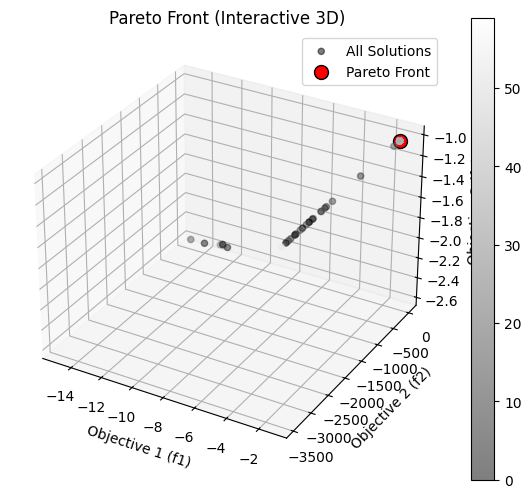

In [73]:
import matplotlib.pyplot as plt
import torch
from mpl_toolkits.mplot3d import Axes3D
from botorch.utils.multi_objective.pareto import is_non_dominated

# Ensure train_obj is a PyTorch tensor
train_obj = torch.tensor(y_measured, dtype=torch.float32)

# Compute Pareto front
pareto_mask = is_non_dominated(train_obj)
pareto_points = train_obj[pareto_mask]

# Enable interactive mode
plt.ion()

# Create figure and 3D axis
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot all solutions (gray points)
im = ax.scatter(train_obj[:, 0], train_obj[:, 1], train_obj[:, 2], c=np.arange(len(train_obj)), cmap='gray',
                alpha=0.5, label="All Solutions")

# Plot Pareto-optimal solutions (red points)
ax.scatter(pareto_points[:, 0], pareto_points[:, 1], pareto_points[:, 2],
           color='red', edgecolors='black', s=100, label="Pareto Front")

# Labels and title
ax.set_xlabel("Objective 1 (f1)")
ax.set_ylabel("Objective 2 (f2)")
ax.set_zlabel("Objective 3 (f3)")
ax.set_title("Pareto Front (Interactive 3D)")
ax.legend()

plt.colorbar(im, ax=ax)

# Show plot (interactive mode enabled)
# plt.show()

# plt.savefig('output/250210-qNEHVI pareto 3D plot new 2.png', dpi=400, bbox_inches='tight', pad_inches=0.1)


Text(0.5, 1.0, 'Hypervolume Convergence Over Iterations')

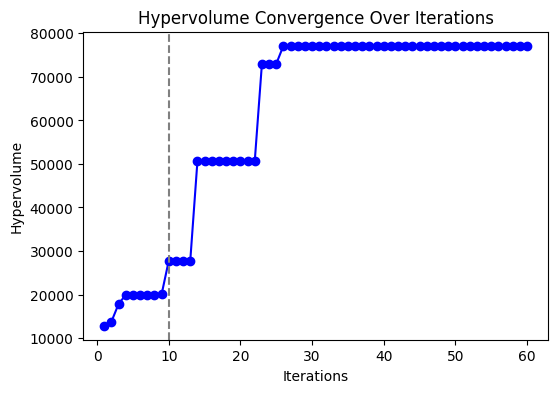

In [75]:
from botorch.utils.multi_objective.hypervolume import Hypervolume
from botorch.utils.multi_objective.pareto import is_non_dominated

# Define reference point for hypervolume computation
ref_point = torch.min(train_obj, dim=0).values - 0.1  # Adjust as needed

# Compute hypervolume at each iteration
hypervolumes = []
for i in range(1, len(train_obj) + 1):
    pareto_mask = is_non_dominated(train_obj[:i])
    pareto_front = train_obj[:i][pareto_mask]
    hypervolumes.append(Hypervolume(ref_point).compute(pareto_front))

# Plot hypervolume over iterations
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_obj) + 1), hypervolumes, marker='o', color='blue')
plt.axvline(10, linestyle='--', color='gray')
plt.xlabel("Iterations")
plt.ylabel("Hypervolume")
plt.title("Hypervolume Convergence Over Iterations")
# plt.show()
# plt.savefig('output/250210-qNEHVI training gain curve new 2.png', dpi=400, bbox_inches='tight', pad_inches=0.1)



In [ ]:
# import pandas as pd
# import seaborn as sns

# # Convert Pareto points to a Pandas DataFrame
# pareto_df = pd.DataFrame(pareto_points.numpy(), columns=[f"Objective {i+1}" for i in range(pareto_points.shape[1])])

# # Plot parallel coordinates
# plt.figure(figsize=(10, 5))
# sns.lineplot(data=pareto_df, dashes=False, alpha=0.7)
# plt.title("Parallel Coordinate Plot of Pareto Front")
# plt.xlabel("Objectives")
# plt.ylabel("Objective Value")
# plt.show()



# Human-in-the-loop MOBO

In [78]:
# Everytime we need to re-load the saved pickle file to make sure the weights in the model remains the same

exp_hMOBO = Experiment()
# save the exp.param with pickle
import pickle
pname = 'mobo_qEHVI.pkl'

# Load the dictionary from a file
with open("mobo_qEHVI.pkl", "rb") as file:  # Use "rb" mode to read in binary format
    exp_hMOBO.param = pickle.load(file)

## Re-train with added weights

In [87]:
def train_mobo_weighted(train_x, train_obj, X, param, acquisition='qNEHVI', beta=4, delta=5, MC_SAMPLES = 128, rew_weight=[1,1,1], ref_weight=[1,1,1],
              N_BATCH = 20, BATCH_SIZE=1, NUM_RESTARTS = 20, EPSILON=0.05, RAW_SAMPLES = 512):
    rew_weight = torch.tensor(rew_weight, dtype=torch.float64)
    ref_weight = torch.tensor(ref_weight, dtype=torch.float64)

    if len(train_x[0]) == 2:
        bounds = torch.stack([torch.ones(2), 1 * torch.ones(2)]).to(param['device'])
        standard_bounds = torch.zeros(2, 2, dtype=torch.float64).to(param['device'])
        standard_bounds[1] = 1
    elif len(train_x[0]) == 3:
        bounds = torch.stack([torch.ones(3), 1 * torch.ones(3)]).to(param['device'])
        standard_bounds = torch.zeros(2, 3, dtype=torch.float64).to(param['device'])
        standard_bounds[1] = 1
    else:
        print("Only 2 and 3 variables are supported!")

    models = []

    for i in range(train_obj.shape[-1]):
        train_obj[..., i : i + 1] = train_obj[..., i : i + 1] * 1
        train_y = train_obj[..., i : i + 1]
        models.append(
            SingleTaskGP(
                train_x, train_y, #outcome_transform=Standardize(m=1)
            )
        )

    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    fit_gpytorch_mll(mll)

    # if sampler is None:
    sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

    if acquisition == 'qNEHVI':
        if EPSILON is not None:
            # Define an ε-dominance threshold (relative to objective range)
            # Normalize objectives
            Y_min, Y_max = train_obj.min(dim=0).values, train_obj.max(dim=0).values
            Y_norm = (train_obj - Y_min) / (Y_max - Y_min)
            for i in range(train_obj.shape[-1]):
                Y_norm[..., i : i + 1] = Y_norm[..., i : i + 1] * rew_weight[i]

            def is_epsilon_dominated(Y, epsilon=0.01):
                """ Returns a boolean mask for non-ε-dominated points. """
                pareto_mask = is_non_dominated(Y)  # Get standard Pareto front
                pareto_points = Y[pareto_mask]  # Extract non-dominated points

                filtered_mask = torch.zeros_like(pareto_mask, dtype=torch.bool)  # Start with False

                for i, p in enumerate(pareto_points):
                    if all(torch.any(p - q > epsilon) for q in Y):
                        filtered_mask[i] = True  # Keep only if it is distinct

                return filtered_mask

            # Apply ε-dominance on normalized values
            pareto_mask = is_epsilon_dominated(Y_norm, epsilon=EPSILON)

            filtered_train_obj = train_obj[pareto_mask]  # Keep only non-ε-dominated points
            filtered_train_x = train_x[pareto_mask]  # Corresponding input points

            if filtered_train_obj.numel() == 0:  # If empty, use standard Pareto front
                filtered_train_obj = train_obj  # Fall back to the original data

            if filtered_train_x.numel() == 0:  # If empty, use standard Pareto front
                filtered_train_x = train_x  # Fall back to the original data

            # Compute the reference point using the filtered Pareto front
            filtered_ref_point = torch.max(filtered_train_obj, dim=0).values - delta * ref_weight  # Adjusted reference point

            # Define qNEHVI Acquisition Function with ε-filtered data
            acq_func = qNoisyExpectedHypervolumeImprovement(
                model=model,
                ref_point=filtered_ref_point,  # Use the filtered reference point
                X_baseline=normalize(filtered_train_x, bounds),  # Only use non-ε-dominated points
                prune_baseline=True,  # Remove points with zero probability of Pareto optimality
                sampler=sampler,

            )

    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200, },
        sequential=True,
    )

    # predict over the unmeasured elements
    x_list = [X, X, X]

    return candidates

In [88]:
weights = np.linspace(0.5, 1.5, 11)
weights

array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5])

In [90]:
next_phase = []
next_amp = []

# trainx = exp_hMOBO.param['X_measured_tensor']
# trainy = exp_hMOBO.param['y_measured_tensor']
# X = exp_hMOBO.param['X_tensor']

for i in range(len(weights)):

    exp_hMOBO = Experiment()
    # Load the dictionary from a file
    with open("mobo_qEHVI.pkl", "rb") as file:  # Use "rb" mode to read in binary format
        exp_hMOBO.param = pickle.load(file)

    trainx = exp_hMOBO.param['X_measured_tensor']
    trainy = exp_hMOBO.param['y_measured_tensor']
    X = exp_hMOBO.param['X_tensor']
    next_temp = train_mobo_weighted(trainx, trainy, X, exp_hMOBO.param, rew_weight=[1, weights[i], 1])
    next_phase.append(next_temp)

    next_temp = train_mobo_weighted(trainx, trainy, X, exp_hMOBO.param, rew_weight=[weights[i], 1, 1])
    next_amp.append(next_temp)

In [91]:
next_phase = np.array(next_phase)
next_amp = np.array(next_amp)
next_phase.shape

(11, 1, 2)

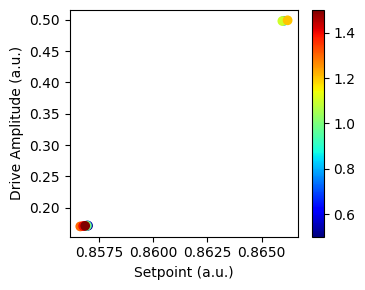

In [92]:
plt.figure(figsize=[3.75,3])
plt.scatter(next_phase[:,0,1], next_phase[:, 0, 0], c=weights, cmap='jet')
plt.colorbar()
plt.xlabel('Setpoint (a.u.)')
plt.ylabel('Drive Amplitude (a.u.)')
plt.title('Add weight to phase reward')

plt.tight_layout()
# plt.xlim(0, 1)
# plt.ylim(0, 1)

# plt.savefig('output/{} weighted phase physical unit 01.png'.format(save), dpi=400, bbox_inches='tight', pad_inches=0.1)


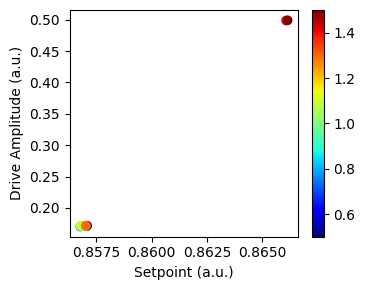

In [93]:
plt.figure(figsize=[3.75,3])
plt.scatter(next_amp[:,0, 1], next_amp[:,0, 0], c=weights, cmap='jet')
plt.colorbar()
plt.xlabel('Setpoint (a.u.)')
plt.ylabel('Drive Amplitude (a.u.)')
plt.title('Add weight to trace reward')

plt.tight_layout()
# plt.xlim(0, 1)
# plt.ylim(0, 1)

# plt.savefig('output/{} weighted phase physical unit 01.png'.format(save), dpi=400, bbox_inches='tight', pad_inches=0.1)


## Shift the reference points to achieve human-in-the-loop

In [94]:
next_phase = []
next_amp = []

# trainx = exp_hMOBO.param['X_measured_tensor']
# trainy = exp_hMOBO.param['y_measured_tensor']
# X = exp_hMOBO.param['X_tensor']

for i in range(len(weights)):

    exp_hMOBO = Experiment()
    # Load the dictionary from a file
    with open("mobo_qEHVI.pkl", "rb") as file:  # Use "rb" mode to read in binary format
        exp_hMOBO.param = pickle.load(file)

    trainx = exp_hMOBO.param['X_measured_tensor']
    trainy = exp_hMOBO.param['y_measured_tensor']
    X = exp_hMOBO.param['X_tensor']
    next_temp = train_mobo_weighted(trainx, trainy, X, exp_hMOBO.param, ref_weight=[1, weights[i], 1])
    next_phase.append(next_temp)

    next_temp = train_mobo_weighted(trainx, trainy, X, exp_hMOBO.param, ref_weight=[weights[i], 1, 1])
    next_amp.append(next_temp)

In [95]:
next_phase = np.array(next_phase)
next_amp = np.array(next_amp)
next_phase.shape

(11, 1, 2)

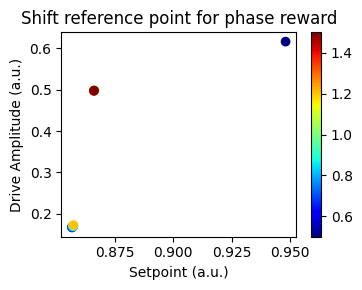

In [98]:
plt.figure(figsize=[3.75,3])
plt.scatter(next_phase[:,0,1], next_phase[:, 0, 0], c=weights, cmap='jet')
plt.colorbar()
plt.xlabel('Setpoint (a.u.)')
plt.ylabel('Drive Amplitude (a.u.)')
plt.title('Shift reference point for phase reward')
plt.tight_layout()
# plt.xlim(0, 1)
# plt.ylim(0, 1)

# plt.savefig('output/{} weighted phase physical unit 01.png'.format(save), dpi=400, bbox_inches='tight', pad_inches=0.1)


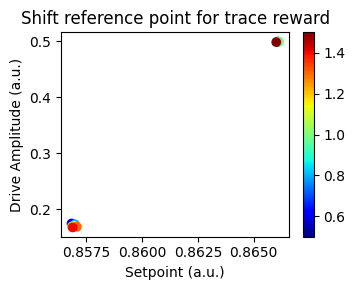

In [99]:
plt.figure(figsize=[3.75,3])
plt.scatter(next_amp[:,0, 1], next_amp[:,0, 0], c=weights, cmap='jet')
plt.colorbar()
plt.xlabel('Setpoint (a.u.)')
plt.ylabel('Drive Amplitude (a.u.)')
plt.title('Shift reference point for trace reward')

plt.tight_layout()
# plt.xlim(0, 1)
# plt.ylim(0, 1)

# plt.savefig('output/{} weighted phase physical unit 01.png'.format(save), dpi=400, bbox_inches='tight', pad_inches=0.1)
